<a href="https://colab.research.google.com/github/syedanida/Multi-modal-language-model-use-exercise/blob/main/catchup_Quiz_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Language Models Demonstration

In [ ]:
# 1: Installation and Setup
"""
First, we'll install the required libraries for working with multimodal models.
These include transformers, PIL for image processing, and other utilities.
"""
!pip install transformers torch torchvision pillow gradio accelerate datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 2: Import Required Libraries
"""
Import all necessary libraries for image processing, model loading, and visualization.
"""
import torch
from transformers import (
    CLIPProcessor, CLIPModel,
    BlipProcessor, BlipForConditionalGeneration,
    BlipForImageTextRetrieval,
    AutoProcessor, AutoModelForVision2Seq,
    pipeline,
    BlipForQuestionAnswering
)
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# 3: Utility Functions
"""
Helper functions for image loading and visualization
"""
def load_image_from_url(url: str) -> Image.Image:
    """Load an image from a URL"""
    return Image.open(requests.get(url, stream=True).raw)

def display_images_with_captions(images: List[Image.Image], captions: List[str],
                               titles: List[str] = None, figsize=(15, 5)):
    """Display multiple images with their captions"""
    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=figsize)
    if n_images == 1:
        axes = [axes]

    for i, (img, caption) in enumerate(zip(images, captions)):
        axes[i].imshow(img)
        axes[i].set_title(titles[i] if titles else f"Image {i+1}")
        axes[i].axis('off')
        axes[i].text(0.5, -0.1, caption, transform=axes[i].transAxes,
                    ha='center', wrap=True, fontsize=10)

    plt.tight_layout()
    plt.show()

Loading CLIP model...


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

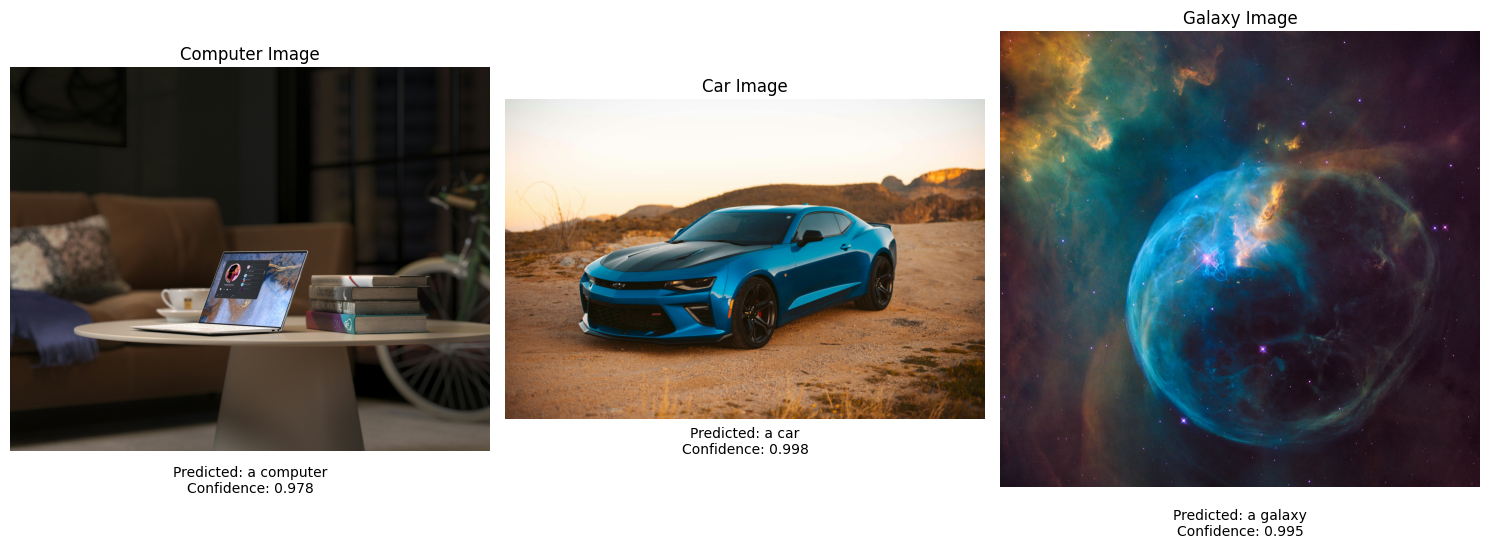

In [ ]:
# 4: Use Case 1 - Zero-Shot Image Classification with CLIP
"""
CLIP (Contrastive Language-Image Pre-training) can perform zero-shot image classification
by comparing image and text embeddings.
"""
print("Loading CLIP model...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Example images for classification
image_urls = [
    "https://images.unsplash.com/photo-1593642634443-44adaa06623a",  # Computer
    "https://images.unsplash.com/photo-1552519507-da3b142c6e3d",  # Car
    "https://images.unsplash.com/photo-1462331940025-496dfbfc7564"   # Galaxy
]

images = [load_image_from_url(url) for url in image_urls]

# Define candidate labels
labels = ["a computer", "a car", "a galaxy", "a dog", "a building"]

# Perform zero-shot classification
def zero_shot_classification(images: List[Image.Image], labels: List[str]):
    """Perform zero-shot image classification using CLIP"""
    results = []

    for img in images:
        inputs = clip_processor(text=labels, images=img, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1)

        # Get the most likely label
        max_prob_idx = probs.argmax().item()
        results.append({
            'label': labels[max_prob_idx],
            'confidence': probs[0][max_prob_idx].item()
        })

    return results

# Run classification
classification_results = zero_shot_classification(images, labels)

# Display results
captions = [f"Predicted: {res['label']}\nConfidence: {res['confidence']:.3f}"
           for res in classification_results]
display_images_with_captions(images, captions,
                           titles=["Computer Image", "Car Image", "Galaxy Image"])

Loading BLIP model for image captioning...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

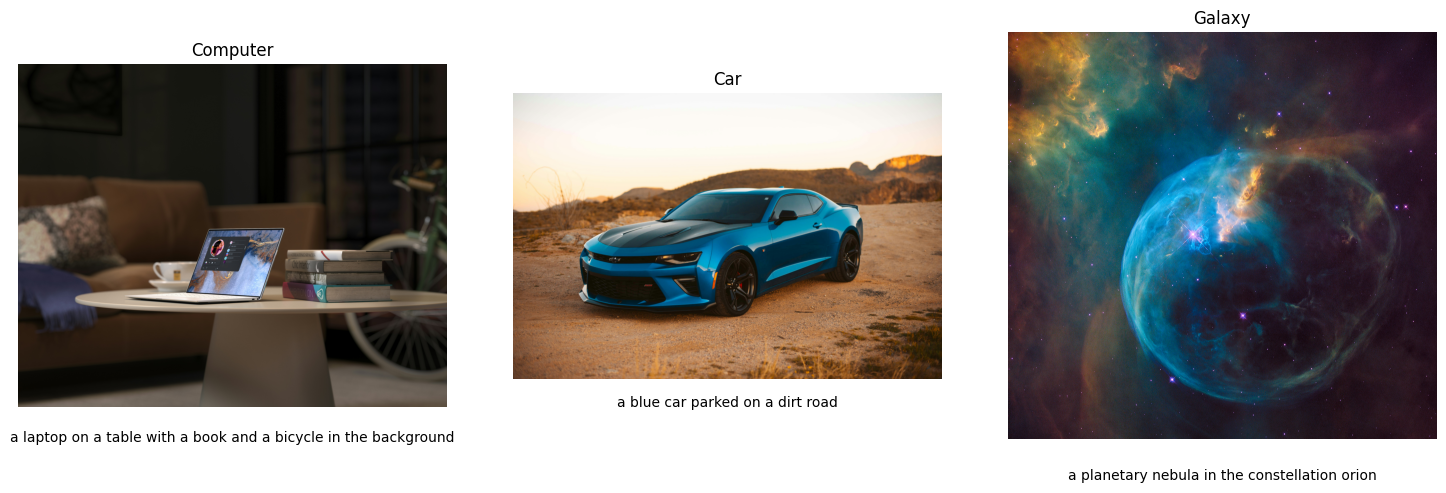

In [ ]:
# 5: Use Case 2 - Image Captioning with BLIP
"""
BLIP (Bootstrapping Language-Image Pre-training) can generate descriptive captions for images.
"""
print("Loading BLIP model for image captioning...")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

# Generate captions for our images
def generate_captions(images: List[Image.Image], max_length: int = 30) -> List[str]:
    """Generate captions for a list of images using BLIP"""
    captions = []

    for img in images:
        inputs = blip_processor(img, return_tensors="pt").to(device)

        with torch.no_grad():
            out = blip_model.generate(**inputs, max_length=max_length)
            caption = blip_processor.decode(out[0], skip_special_tokens=True)

        captions.append(caption)

    return captions

# Generate captions
generated_captions = generate_captions(images)

# Display images with generated captions
display_images_with_captions(images, generated_captions,
                           titles=["Computer", "Car", "Galaxy"])

Loading BLIP VQA model...


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

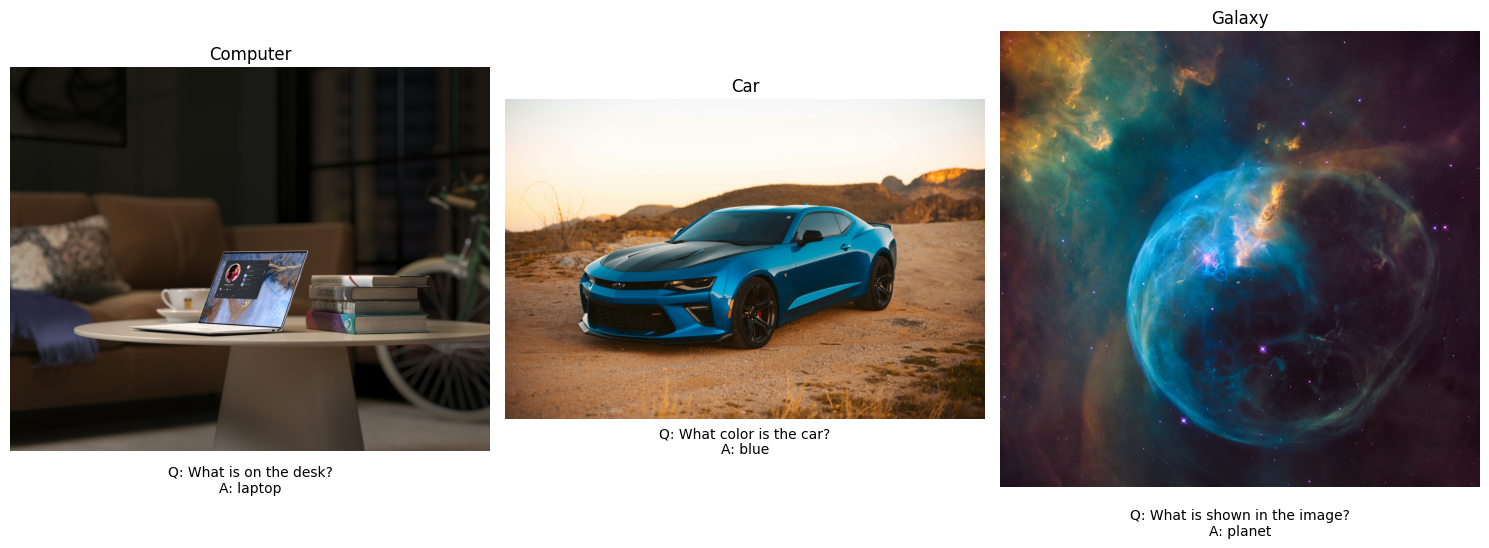

In [ ]:
# 6: Use Case 3 - Visual Question Answering (VQA)
"""
Visual Question Answering allows us to ask questions about images and get relevant answers.
"""
print("Loading BLIP VQA model...")
vqa_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)

# Define questions for each image
questions = [
    "What is on the desk?",
    "What color is the car?",
    "What is shown in the image?"
]

# Perform VQA
def visual_question_answering(images: List[Image.Image], questions: List[str]) -> List[str]:
    """Perform visual question answering on images"""
    answers = []

    for img, question in zip(images, questions):
        inputs = vqa_processor(img, question, return_tensors="pt").to(device)

        with torch.no_grad():
            out = vqa_model.generate(**inputs)
            answer = vqa_processor.decode(out[0], skip_special_tokens=True)

        answers.append(answer)

    return answers

# Get answers
answers = visual_question_answering(images, questions)

# Display results
vqa_captions = [f"Q: {q}\nA: {a}" for q, a in zip(questions, answers)]
display_images_with_captions(images, vqa_captions,
                           titles=["Computer", "Car", "Galaxy"])

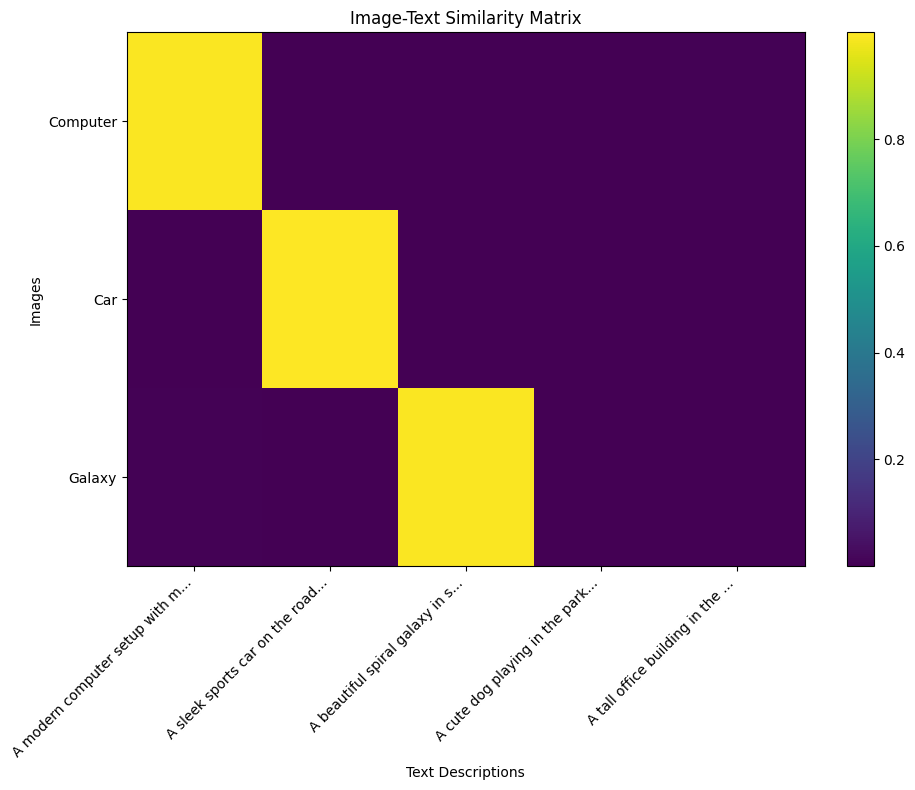

In [ ]:
# 7: Use Case 4 - Image-Text Similarity with CLIP
"""
CLIP can compute similarity scores between images and text descriptions.
This is useful for image retrieval and matching.
"""
def compute_image_text_similarity(images: List[Image.Image], texts: List[str]) -> np.ndarray:
    """Compute similarity scores between images and texts"""
    inputs = clip_processor(text=texts, images=images, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        similarity_scores = logits_per_image.softmax(dim=1)

    return similarity_scores.cpu().numpy()

# Define text descriptions
text_descriptions = [
    "A modern computer setup with multiple screens",
    "A sleek sports car on the road",
    "A beautiful spiral galaxy in space",
    "A cute dog playing in the park",
    "A tall office building in the city"
]

# Compute similarities
similarity_matrix = compute_image_text_similarity(images, text_descriptions)

# Visualize similarity matrix
plt.figure(figsize=(10, 8))
im = plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
plt.colorbar(im)
plt.xlabel('Text Descriptions')
plt.ylabel('Images')
plt.title('Image-Text Similarity Matrix')
plt.xticks(range(len(text_descriptions)), [desc[:30] + '...' for desc in text_descriptions],
          rotation=45, ha='right')
plt.yticks(range(len(images)), ['Computer', 'Car', 'Galaxy'])
plt.tight_layout()
plt.show()


Query: 'A wild animal in nature'


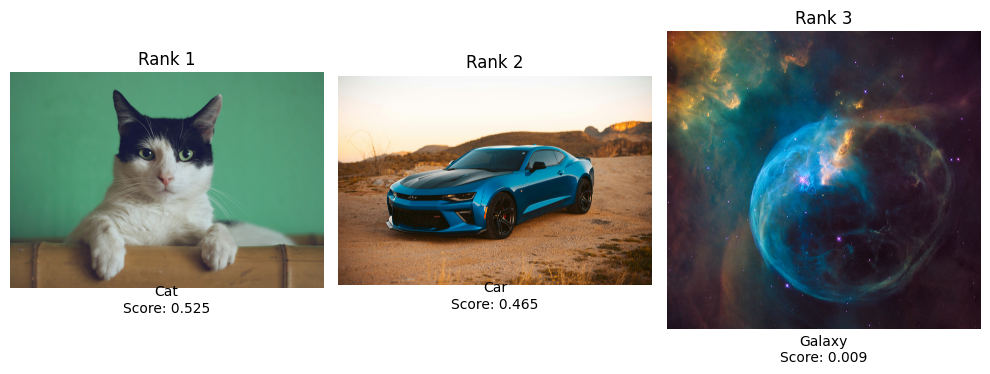


Query: 'Technology and computers'


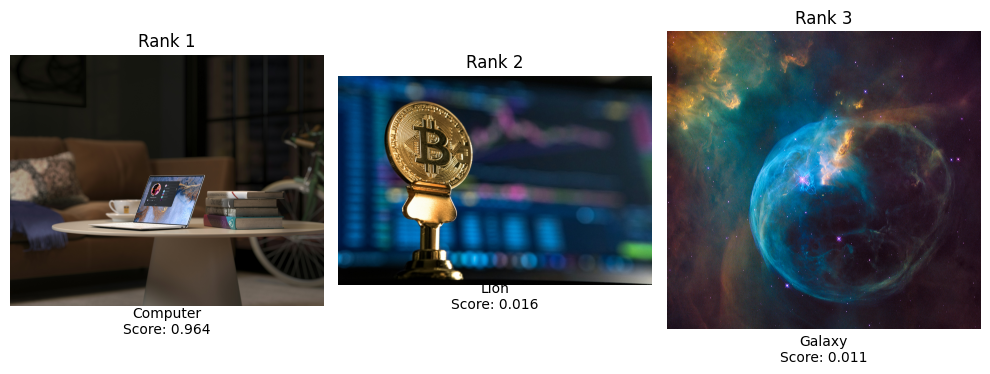


Query: 'Space and astronomy'


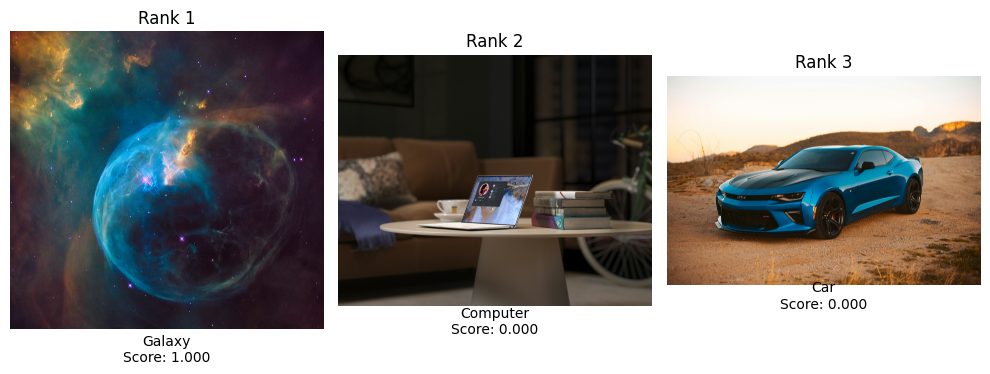

In [ ]:
# 8: Use Case 5 - Text-to-Image Retrieval
"""
Given a text query, find the most relevant images from a collection.
"""
# Load more diverse images for retrieval
additional_image_urls = [
    "https://images.unsplash.com/photo-1516245834210-c4c142787335",  # Lion
    "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba",  # Cat
]

all_images = images + [load_image_from_url(url) for url in additional_image_urls]
image_names = ["Computer", "Car", "Galaxy", "Lion", "Cat"]

# Text queries for retrieval
text_queries = [
    "A wild animal in nature",
    "Technology and computers",
    "Space and astronomy"
]

def retrieve_images(text_query: str, images: List[Image.Image], top_k: int = 3) -> List[Tuple[int, float]]:
    """Retrieve top-k most relevant images for a text query"""
    inputs = clip_processor(text=[text_query], images=images, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits_per_text = outputs.logits_per_text
        similarities = logits_per_text.softmax(dim=1).squeeze()

    # Get top-k indices
    top_k_indices = similarities.argsort(descending=True)[:top_k]
    top_k_scores = similarities[top_k_indices]

    return [(idx.item(), score.item()) for idx, score in zip(top_k_indices, top_k_scores)]

# Perform retrieval for each query
for query in text_queries:
    print(f"\nQuery: '{query}'")
    results = retrieve_images(query, all_images, top_k=3)

    # Display retrieved images
    retrieved_images = [all_images[idx] for idx, _ in results]
    retrieved_captions = [f"{image_names[idx]}\nScore: {score:.3f}"
                         for idx, score in results]

    display_images_with_captions(retrieved_images, retrieved_captions,
                               titles=[f"Rank {i+1}" for i in range(len(retrieved_images))],
                               figsize=(10, 4))

In [ ]:
# 9: Use Case 6 - Advanced Image Understanding with LLaVA
"""
Using more advanced multimodal models for complex image understanding tasks.
Note: This requires a more powerful model and might need more resources.
"""
# For demonstration, we'll use a smaller model
print("Loading advanced multimodal model...")
try:
    processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")
    model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224").to(device)

    # Complex image understanding example
    test_image = images[0]  # Computer image

    # Generate detailed description
    prompt = "Describe this image in detail:"

    inputs = processor(text=prompt, images=test_image, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=100,
            num_beams=3,
            do_sample=True,
            temperature=0.7
        )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    print(f"Detailed Description:\n{generated_text}")

except Exception as e:
    print(f"Could not load advanced model: {e}")
    print("This model requires more resources. Using BLIP instead for detailed caption.")

    # Fallback to BLIP for detailed caption
    inputs = blip_processor(images[0], "Describe this image in detail", return_tensors="pt").to(device)
    out = blip_model.generate(**inputs, max_length=50)
    detailed_caption = blip_processor.decode(out[0], skip_special_tokens=True)
    print(f"Detailed Caption:\n{detailed_caption}")

Loading advanced multimodal model...


preprocessor_config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/191k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Detailed Description:
<image>. the, to and of as in I that' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image> Describe this image in detail: A laptop is sitting on a coffee table in a living room. The laptop is open, displaying the Microsoft Edge browser. There is a stack of books next to the laptop, and a cup of coffee is placed on the table. In the background, there is a couch and a bicycle. A potted plant can be seen on the left side of the room, adding a touch of greenery to the space.


In [ ]:
# 10: Performance Comparison and Analysis
"""
Compare the performance of different models on various tasks
"""
# Create a summary of model capabilities
model_comparison = {
    'CLIP': {
        'Tasks': ['Zero-shot classification', 'Image-text similarity', 'Text-to-image retrieval'],
        'Strengths': 'Versatile, good for classification and retrieval',
        'Limitations': 'Cannot generate text descriptions'
    },
    'BLIP': {
        'Tasks': ['Image captioning', 'Visual question answering'],
        'Strengths': 'Good at generating descriptive text',
        'Limitations': 'Less flexible for zero-shot tasks'
    },
    'Advanced Models (LLaVA, Kosmos)': {
        'Tasks': ['Complex reasoning', 'Detailed descriptions', 'Multi-turn conversations'],
        'Strengths': 'Most capable for complex tasks',
        'Limitations': 'Require more computational resources'
    }
}

# Display comparison
for model_name, info in model_comparison.items():
    print(f"\n{model_name}:")
    print(f"Tasks: {', '.join(info['Tasks'])}")
    print(f"Strengths: {info['Strengths']}")
    print(f"Limitations: {info['Limitations']}")


CLIP:
Tasks: Zero-shot classification, Image-text similarity, Text-to-image retrieval
Strengths: Versatile, good for classification and retrieval
Limitations: Cannot generate text descriptions

BLIP:
Tasks: Image captioning, Visual question answering
Strengths: Good at generating descriptive text
Limitations: Less flexible for zero-shot tasks

Advanced Models (LLaVA, Kosmos):
Tasks: Complex reasoning, Detailed descriptions, Multi-turn conversations
Strengths: Most capable for complex tasks
Limitations: Require more computational resources


In [ ]:
# 11: Practical Applications
"""
Real-world applications of multimodal language models
"""
applications = [
    {
        'Application': 'Content Moderation',
        'Description': 'Automatically detect inappropriate content in images',
        'Model': 'CLIP with custom classifiers'
    },
    {
        'Application': 'E-commerce Search',
        'Description': 'Find products using natural language queries',
        'Model': 'CLIP for image-text matching'
    },
    {
        'Application': 'Accessibility',
        'Description': 'Generate alt-text for images for visually impaired users',
        'Model': 'BLIP for image captioning'
    },
    {
        'Application': 'Medical Imaging',
        'Description': 'Analyze medical images and answer questions',
        'Model': 'Specialized VQA models'
    },
    {
        'Application': 'Education',
        'Description': 'Create interactive learning materials with visual explanations',
        'Model': 'Advanced multimodal models'
    }
]

print("Practical Applications of Multimodal Models:\n")
for app in applications:
    print(f"• {app['Application']}: {app['Description']}")
    print(f"  Recommended Model: {app['Model']}\n")

Practical Applications of Multimodal Models:

• Content Moderation: Automatically detect inappropriate content in images
  Recommended Model: CLIP with custom classifiers

• E-commerce Search: Find products using natural language queries
  Recommended Model: CLIP for image-text matching

• Accessibility: Generate alt-text for images for visually impaired users
  Recommended Model: BLIP for image captioning

• Medical Imaging: Analyze medical images and answer questions
  Recommended Model: Specialized VQA models

• Education: Create interactive learning materials with visual explanations
  Recommended Model: Advanced multimodal models



In [ ]:
# 12: Interactive Demo (Optional)
"""
Create an interactive demo using Gradio
"""
try:
    import gradio as gr

    def multimodal_demo(image, task, text_input=""):
        """Interactive demo function"""
        if task == "Image Captioning":
            inputs = blip_processor(image, return_tensors="pt").to(device)
            out = blip_model.generate(**inputs, max_length=30)
            result = blip_processor.decode(out[0], skip_special_tokens=True)

        elif task == "Zero-shot Classification":
            labels = text_input.split(',') if text_input else ["object", "animal", "scene", "food"]
            inputs = clip_processor(text=labels, images=image, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = clip_model(**inputs)
                probs = outputs.logits_per_image.softmax(dim=1)

            max_idx = probs.argmax().item()
            result = f"Predicted: {labels[max_idx]} (Confidence: {probs[0][max_idx]:.3f})"

        elif task == "Visual Question Answering":
            if not text_input:
                text_input = "What is in this image?"

            inputs = vqa_processor(image, text_input, return_tensors="pt").to(device)
            out = vqa_model.generate(**inputs)
            result = vqa_processor.decode(out[0], skip_special_tokens=True)

        else:
            result = "Please select a valid task"

        return result

    # Create Gradio interface
    demo = gr.Interface(
        fn=multimodal_demo,
        inputs=[
            gr.Image(type="pil", label="Upload Image"),
            gr.Dropdown(
                choices=["Image Captioning", "Zero-shot Classification", "Visual Question Answering"],
                label="Select Task"
            ),
            gr.Textbox(
                label="Text Input (for classification: comma-separated labels; for VQA: your question)",
                placeholder="Optional: Enter labels or question"
            )
        ],
        outputs=gr.Textbox(label="Result"),
        title="Multimodal Language Model Demo",
        description="Upload an image and select a task to see multimodal AI in action!"
    )

    # Launch the demo
    print("Launching interactive demo...")
    demo.launch(share=True)

except ImportError:
    print("Gradio not installed. Skipping interactive demo.")
except Exception as e:
    print(f"Could not create interactive demo: {e}")

Launching interactive demo...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5c9475c18150af7737.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
